# Create the snapshots

## Download hazard

In [1]:
from climada.util.api_client import Client

client = Client()
future_year = 2080
haz_present = client.get_hazard('tropical_cyclone', 
                                properties={'country_name': 'Haiti', 
                                            'climate_scenario': 'historical',
                                            'nb_synth_tracks':'10'})

haz_future = client.get_hazard('tropical_cyclone', 
                                properties={'country_name': 'Haiti', 
                                            'climate_scenario': 'rcp60',
                                            'ref_year': str(future_year),
                                            'nb_synth_tracks':'10'})

2024-07-08 13:05:01,376 - climada.hazard.io - INFO - Reading /Users/vwattin/climada/data/hazard/tropical_cyclone/tropical_cyclone_10synth_tracks_150arcsec_HTI_1980_2020/v2/tropical_cyclone_10synth_tracks_150arcsec_HTI_1980_2020.hdf5
2024-07-08 13:05:07,495 - climada.hazard.io - INFO - Reading /Users/vwattin/climada/data/hazard/tropical_cyclone/tropical_cyclone_10synth_tracks_150arcsec_rcp60_HTI_2080/v2/tropical_cyclone_10synth_tracks_150arcsec_rcp60_HTI_2080.hdf5


## Download LitPop economic exposure data

In [2]:
exp_present = client.get_litpop(country='Haiti')
current_year = exp_present.ref_year


import copy

exp_future = copy.deepcopy(exp_present)
exp_future.ref_year = future_year
n_years = exp_future.ref_year - exp_present.ref_year + 1
growth_rate = 1.02
growth = growth_rate ** n_years
exp_future.gdf['value'] = exp_future.gdf['value'] * growth

# Rename the impact function column in the exposures and assign hazard IDs

# This is more out of politeness, since if there's only one impact function
# and one `impf_` column, CLIMADA can figure it out
exp_present.gdf.rename(columns={"impf_": "impf_TC"}, inplace=True)
exp_present.gdf['impf_TC'] = 1
exp_future.gdf.rename(columns={"impf_": "impf_TC"}, inplace=True)
exp_future.gdf['impf_TC'] = 1

# This would be done automatically in Impact calculations
# but it's better to do it explicitly before the calculation
exp_present.assign_centroids(haz_present, distance='approx')
exp_future.assign_centroids(haz_future, distance='approx')

2024-07-08 13:05:09,151 - climada.entity.exposures.base - INFO - Reading /Users/vwattin/climada/data/exposures/litpop/LitPop_150arcsec_HTI/v3/LitPop_150arcsec_HTI.hdf5
2024-07-08 13:05:09,188 - climada.entity.exposures.base - INFO - Matching 1329 exposures with 1332 centroids.
2024-07-08 13:05:09,191 - climada.util.coordinates - INFO - No exact centroid match found. Reprojecting coordinates to nearest neighbor closer than the threshold = 100
2024-07-08 13:05:09,580 - climada.entity.exposures.base - INFO - Matching 1329 exposures with 1332 centroids.
2024-07-08 13:05:09,582 - climada.util.coordinates - INFO - No exact centroid match found. Reprojecting coordinates to nearest neighbor closer than the threshold = 100


## Define impact function

In [3]:
from climada.entity import ImpactFuncSet, ImpfTropCyclone

impf_tc = ImpfTropCyclone.from_emanuel_usa()

# Create the ImpactFuncSet object
impf_set = ImpactFuncSet([impf_tc])

## Define adaptation measures

In [4]:
# Define the measure
from climada.entity.measures.base import Measure, helper_hazard, helper_impfset, helper_exposure
from climada.entity.measures import MeasureSet


# Measure 1
meas_1 = Measure(
    haz_type = 'TC',
    name='Measure A', 
    hazard_change = helper_hazard(intensity_multiplier=1, intensity_substract=5), 
    **{'mkt_price_year': exp_present.ref_year, 'init_cost': -5_000_000_000}
    )

# Measure 2
meas_2 = Measure(
    haz_type = 'TC',
    name='Measure B', 
    impfset_change = helper_impfset(
        haz_type = 'TC',
        impf_paa_modifier={1:(1,-0.10)}
        ),
    **{'mkt_price_year': exp_present.ref_year, 'init_cost': -220_000_000}
    )

# gather all measures
meas_set = MeasureSet(measures=[meas_1, meas_2])


## Define discount rates

In [5]:
from climada.entity import DiscRates
import numpy as np

year_range = np.arange(exp_present.ref_year, exp_future.ref_year + 1)
annual_discount_zero = np.zeros(n_years)
annual_discount_stern = np.ones(n_years) * 0.014

discount_zero = DiscRates(year_range, annual_discount_zero)
discount_stern = DiscRates(year_range, annual_discount_stern)

## Create Snapshots (prev. Entity) objects

In [6]:
from climada.engine.option_appraisal.impact_trajectories import Snapshot, SnapshotsCollection, CalcImpactsSnapshots

# Store the hazards and exposure in a list
hazard_list = [haz_present, haz_future]
exposure_list = [exp_present, exp_future]
snapshot_years = [exp_present.ref_year, exp_future.ref_year]

# Create the snapshots
snapshots = SnapshotsCollection.from_lists( hazard_list, exposure_list, impf_set, snapshot_years)

# Step 2 – Calculate the annual risk metrics

In [7]:
from climada.engine.option_appraisal.calc_impact_metrics import CalcImpactMetrics

# Create the impact metrics
cim = CalcImpactMetrics(snapshots, meas_set)
# Create the impact metrics object
im = cim.generate_impact_metrics()

2024-07-08 13:05:09,673 - climada.entity.exposures.base - INFO - Exposures matching centroids already found for TC
2024-07-08 13:05:09,674 - climada.entity.exposures.base - INFO - Existing centroids will be overwritten for TC
2024-07-08 13:05:09,674 - climada.entity.exposures.base - INFO - Matching 1329 exposures with 1332 centroids.
2024-07-08 13:05:09,676 - climada.util.coordinates - INFO - No exact centroid match found. Reprojecting coordinates to nearest neighbor closer than the threshold = 100
2024-07-08 13:05:09,679 - climada.engine.impact_calc - INFO - Calculating impact for 3987 assets (>0) and 43560 events.
2024-07-08 13:05:09,690 - climada.entity.exposures.base - INFO - Exposures matching centroids already found for TC
2024-07-08 13:05:09,690 - climada.entity.exposures.base - INFO - Existing centroids will be overwritten for TC
2024-07-08 13:05:09,690 - climada.entity.exposures.base - INFO - Matching 1329 exposures with 1332 centroids.
2024-07-08 13:05:09,692 - climada.util.c

## Waterfall plot

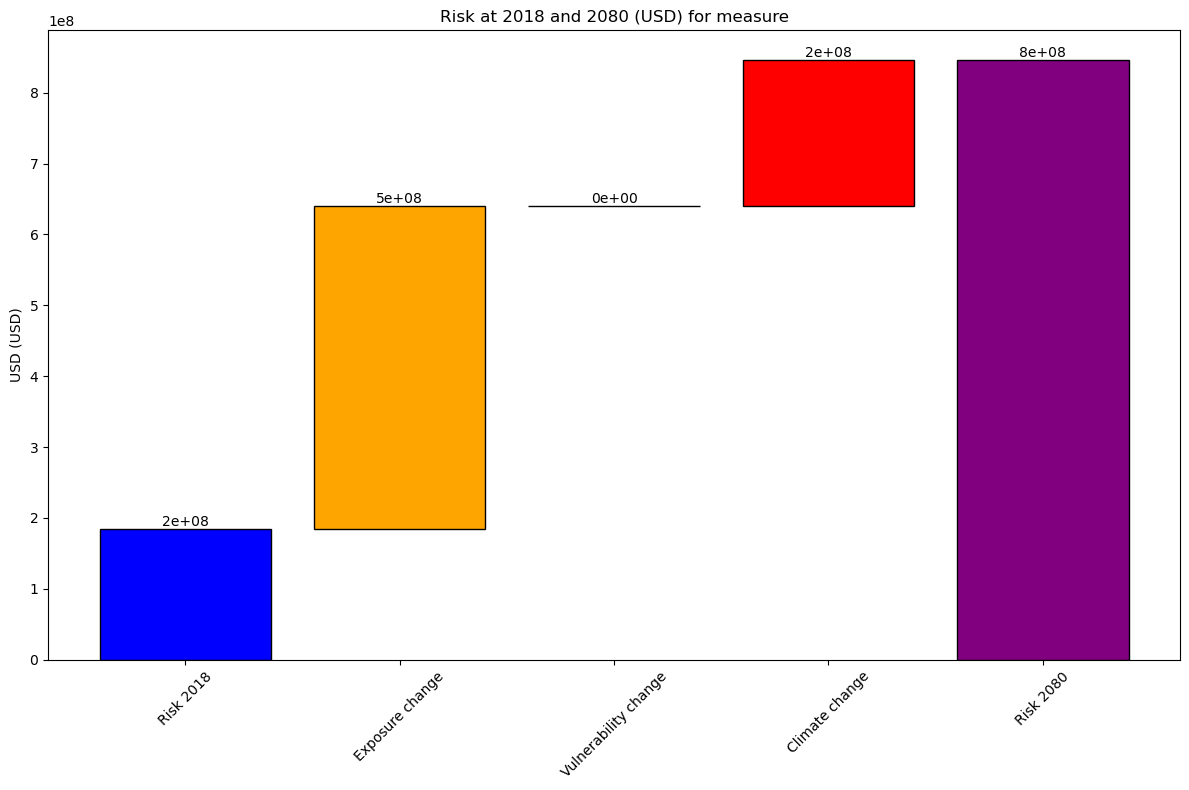

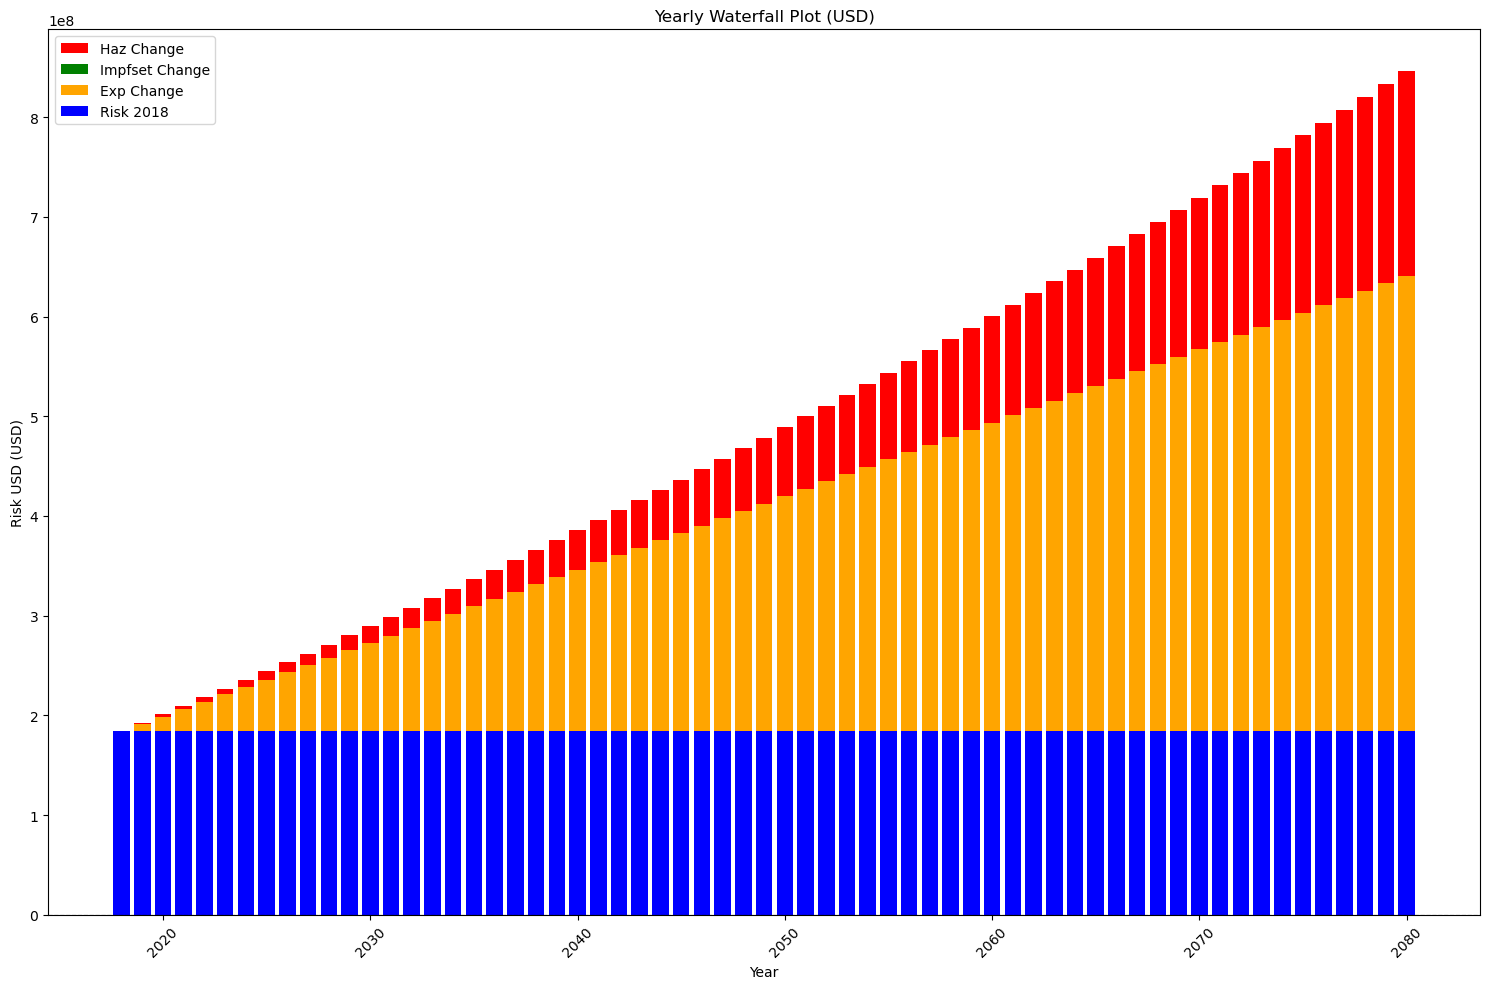

In [8]:
# Plot the classic waterfall
im.waterfall_plot()

# Plot the yearly waterfall
im.waterfall_plot(yearly=True)

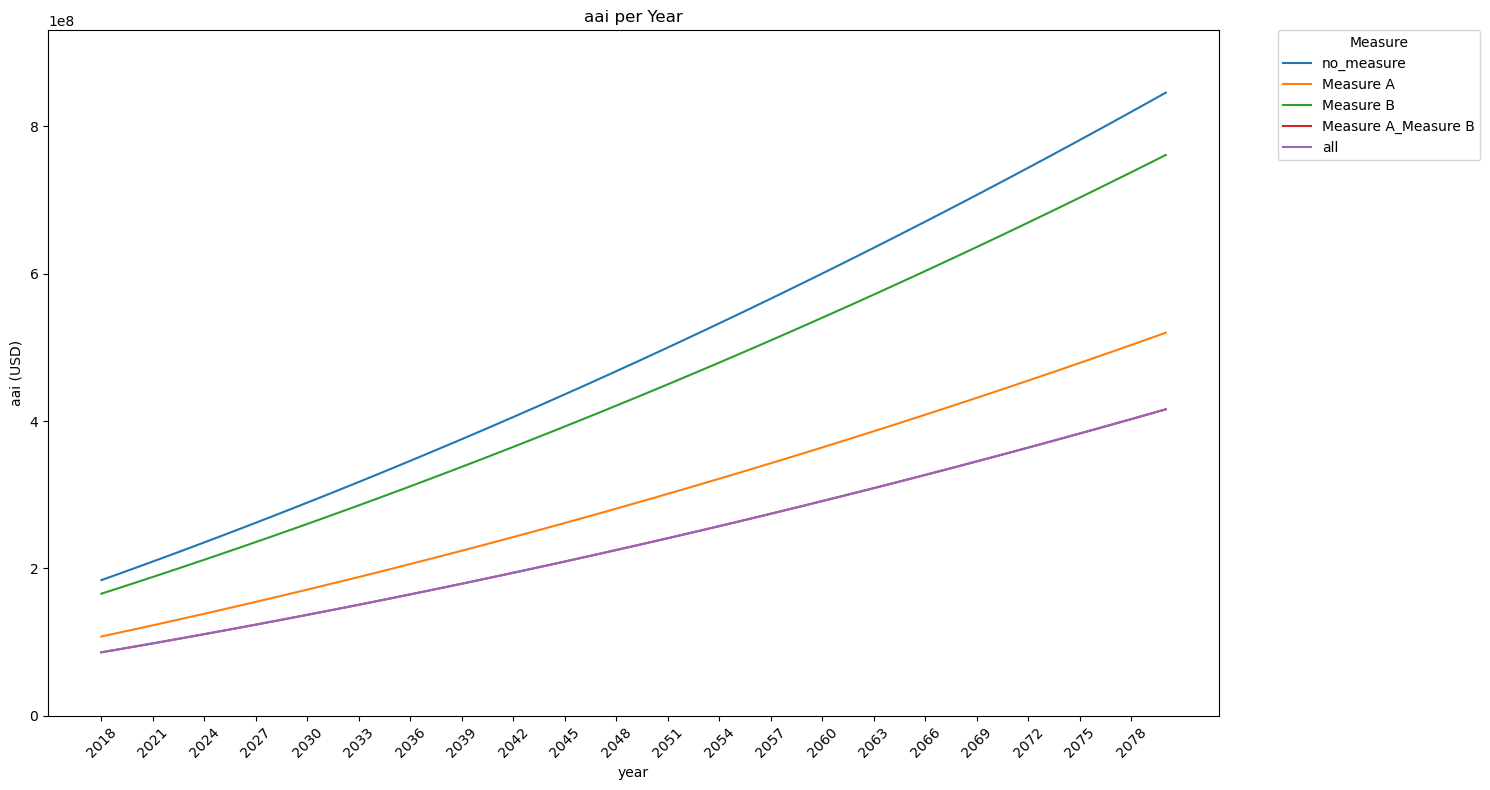

In [11]:
# Plot risk over time - Bar
im.plot_yearly_risk_metrics()

## CB analysis

# Test that the values are correct

In [52]:
from climada.engine import ImpactCalc

# Get the risk metrics from the im object
arms_df = im.get_annual_risk_df()

def get_risk_metrics(exp, impf_set, haz, meas=None, return_per = [100, 500, 1000, 2000]):
    if meas is not None:
        # Apply the measure
        new_exp, new_impfs, new_haz = meas.apply(exp, impf_set, haz)
    else:
        new_exp, new_impfs, new_haz = exp, impf_set, haz

    # Get the risk metrics for the new exposure
    imp = ImpactCalc(new_exp, new_impfs, new_haz).impact(save_mat=False)
    # Get the risk metrics for the new exposure
    aai = imp.aai_agg
    # Get the return periods
    rp = imp.calc_freq_curve(return_per)

    return aai, rp

# Get the risk metrics for the present exposure
exp = exp_present
haz = haz_present
meas = None

aai, freq_curve = get_risk_metrics(exp, impf_set, haz, meas)

print('For the present exposure:')
# Compare to the im object
print('\nAAI:', aai)
for rp, rp_imp in zip(freq_curve.return_per, freq_curve.impact): 
    print(f'rp_{rp}:', rp_imp)
print('\n')


meas_name = 'no_measure'
year = exp.ref_year
metrics = im.get_risk_metrics()

# Get the AAI for the present exposure
for metric in metrics:
    result = arms_df[(arms_df['year'] == year) & (arms_df['measure'] == meas_name) & (arms_df['metric'] == metric)]['result'].values[0]
    print(f'{metric}: {result}')


2024-07-08 16:31:17,426 - climada.entity.exposures.base - INFO - Exposures matching centroids already found for TC


2024-07-08 16:31:17,443 - climada.entity.exposures.base - INFO - Existing centroids will be overwritten for TC
2024-07-08 16:31:17,461 - climada.entity.exposures.base - INFO - Matching 1329 exposures with 1332 centroids.
2024-07-08 16:31:17,484 - climada.util.coordinates - INFO - No exact centroid match found. Reprojecting coordinates to nearest neighbor closer than the threshold = 100
2024-07-08 16:31:17,514 - climada.engine.impact_calc - INFO - Calculating impact for 3987 assets (>0) and 43560 events.
For the present exposure:

AAI: 184043243.15518668
rp_100: 5719049879.034155
rp_500: 19292728636.543633
rp_1000: 19292728636.543633
rp_2000: 19292728636.543633


aai: 184043243.15518668
rp_100: 5719049879.034156
rp_500: 19292728636.54363
rp_1000: 19292728636.54363


['aai', 'rp_100', 'rp_500', 'rp_1000']